In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [13]:
# From Dipole_ideal.ipynb
sim_data_file_path = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/compare_wn_ideal_tf.npy'
sim_data= np.load(sim_data_file_path, allow_pickle=True).item()

In [14]:
def calculate_transfer_function(params, freqs):
    """
    Calculates T_p

    Args:
        params (dict): A dictionary containing the biophysical parameters.
        freqs (np.ndarray): An array of frequencies (in Hz) to calculate the PSD for.

    Returns:
        tuple: A tuple containing:
            - freqs (np.ndarray): The input frequency array.
            - abs_T_p (np.ndarray): The absolute value of the calculated Transfer function for the ball-and-two-stick model.
    """
    # --- 1. Extract parameters and convert to SI units ---
    Rm = params['Rm']  # Specific membrane resistance (Ohm * m^2)
    Ri = params['Ri']  # Axial resistivity (Ohm * m)
    Cm = params['Cm']  # Specific membrane capacitance (F / m^2)
    d = params['d']    # Stick diameter (m)
    ds = params['ds']  # Soma diameter (m)
    l1 = params['l1']  # Length of stick 1 (m)
    l2 = params['l2']  # Length of stick 2 (m)
    s_in = params['s_in'] # PSD of white noise input current (A^2 / Hz)

    # --- 2. Calculate derived cable properties ---
    # Angular frequency
    omega = 2 * np.pi * freqs
    # Add a small epsilon to the first frequency to avoid division by zero if f=0
    omega[0] = omega[0] + 1e-9

    # Membrane time constant (s)
    tau_m = Rm * Cm

    # Length constant (m)
    # This is the standard definition from cable theory (e.g., Rall, 1959)
    lambda_ = np.sqrt((d * Rm) / (4 * Ri))

    # Electrotonic lengths (dimensionless)
    L1 = l1 / lambda_
    L2 = l2 / lambda_

    # Dimensionless frequency
    W = omega * tau_m

    # Complex frequency-dependent term q
    q = np.sqrt(1 + 1j * W)

    # --- 3. Calculate admittances (inverse of impedance) ---
    # Admittance of the soma (S)
    Ys = np.pi * ds**2 * (1/Rm) * q**2

    # Infinite-stick admittance (S)
    G_inf = np.pi * d**2 / (4 * Ri * lambda_)
    Y_inf = q * G_inf

    # Total input admittance seen by the soma (S)
    # This is the parallel sum of the soma and the two finite sticks.
    Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

    # --- 4. Calculate the transfer function T_p(f) ---
    # Derived for the ball-and-two-stick model.
    # The numerator represents the difference in dipole moments from the two sticks.
    numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))

    # The denominator is the total admittance
    denominator = Y_in_total

    T_p = numerator / denominator
    abs_T_p = np.abs(T_p)

    return freqs, abs_T_p

In [15]:
standard_neuron_parameters = {
    'Rm': 3.0,          # Ohm * m^2
    'Ri': 1.5,          # Ohm * m
    'Cm': 0.01,         # F / m^2
    'd': 2e-6,          # 2 µm -> m
    'ds': 20e-6,        # 20 µm -> m
    'l1': 670e-6,       # 670 µm -> m (Longer stick)
    'l2': 330e-6,       # 330 µm -> m (Shorter stick)
    's_in': (1e-15)**2  # 1 fA^2/Hz -> A^2/Hz
}

frequencies = np.logspace(-1, 4, 1000)

In [16]:
# Calculate transfer function for the same properties as used in simulation "white_noise_ideal_to_compare_Tp"
params_one = standard_neuron_parameters.copy()
params_one['l1'] = 1e-3
params_one['l2'] = 0.5*1e-3

# --- Calculate the PSD for the asymmetric case ---
freqs_one, abs_T_p_one = calculate_transfer_function(params_one, frequencies.copy())

# --- For comparison, calculate the PSD for a symmetric case ---
# Here, the lengths are equal, so the net dipole moment should be zero.
params_two = standard_neuron_parameters.copy()
params_two['l1'] = 0.6*1e-3
params_two['l2'] = 0.1*1e-3
params_two['ds'] = 10e-6
freqs_two, abs_T_p_two = calculate_transfer_function(params_two, frequencies.copy())

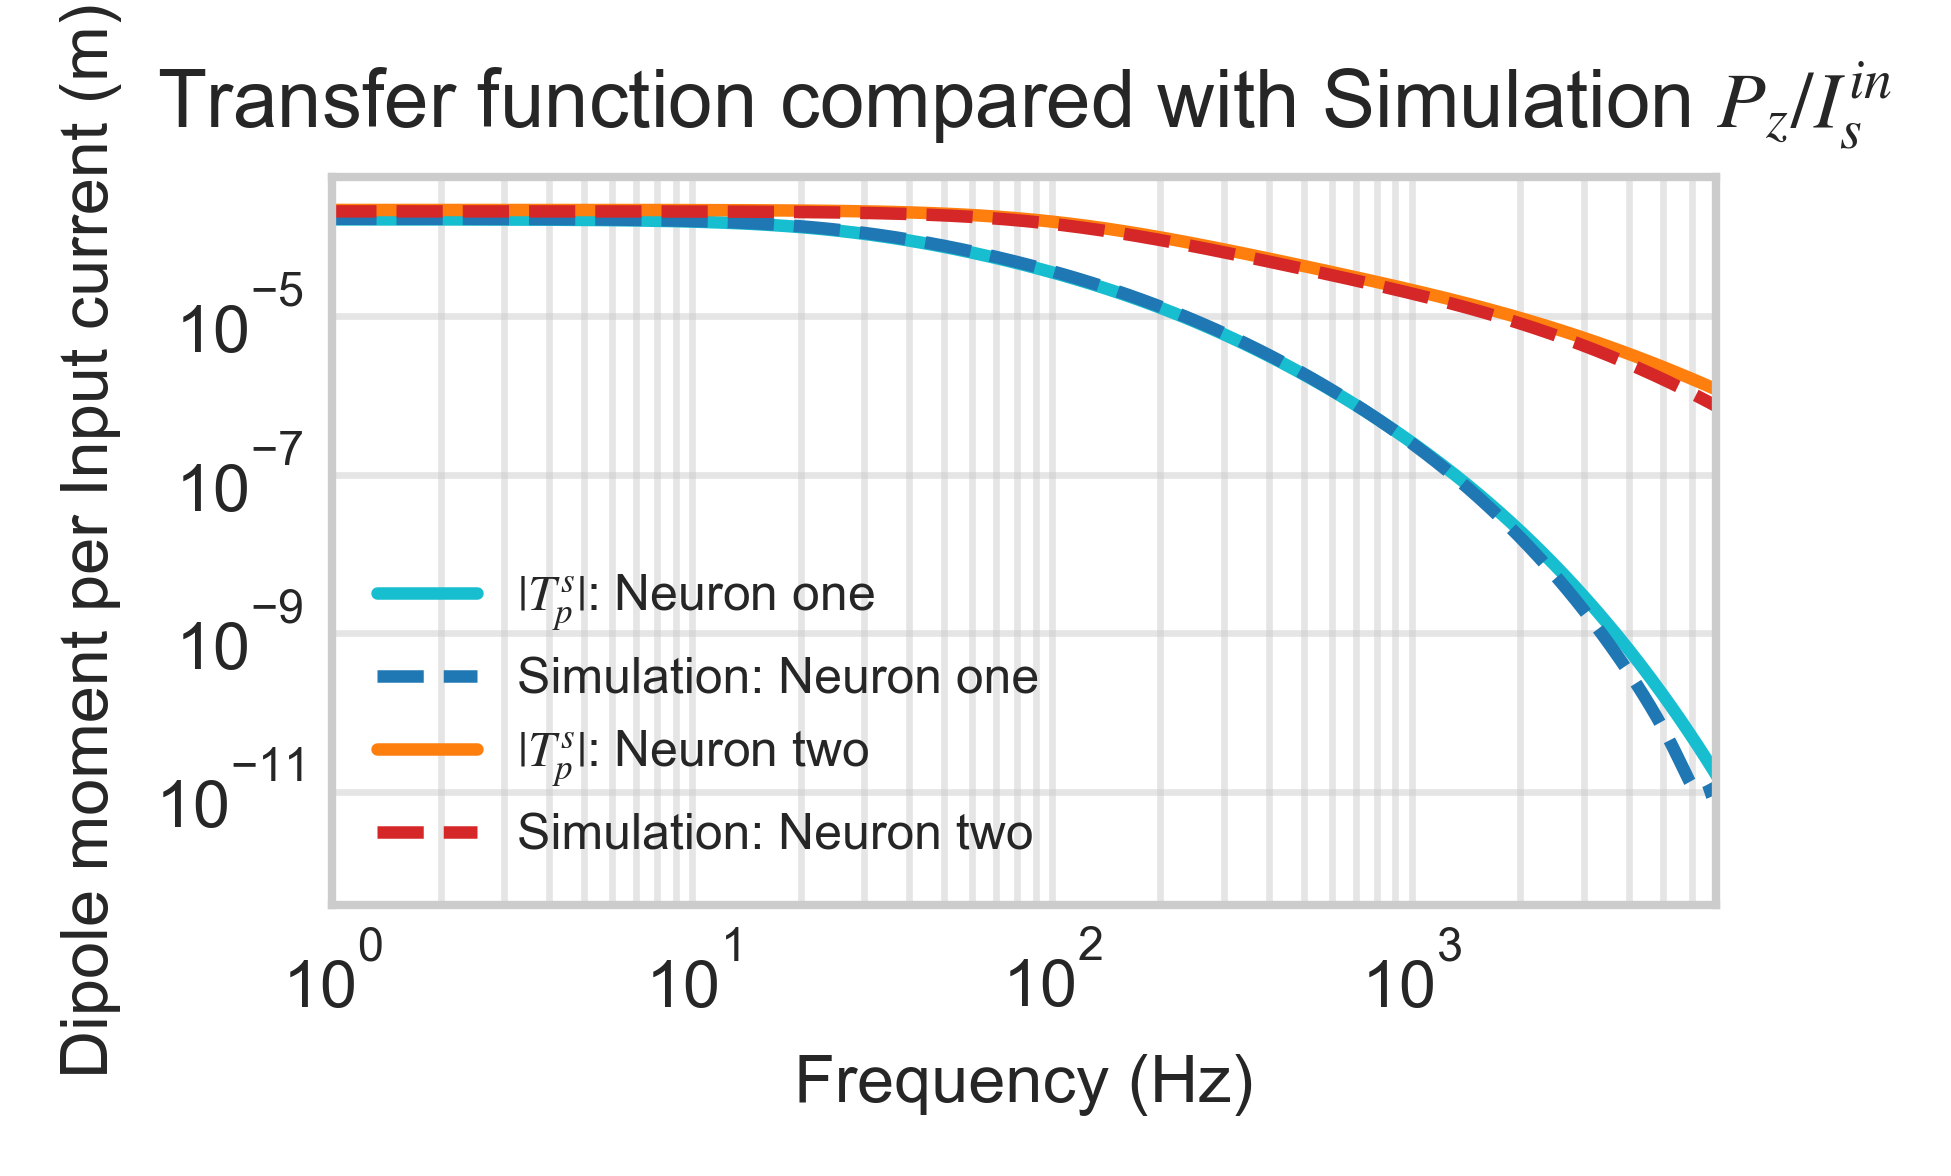

In [17]:
from itertools import islice
# --- Plot normalized PSDs and simulation dipole data ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(3, 2))

plt.rcParams['mathtext.fontset'] = 'stix'

# Neuron 1
ax.loglog(freqs_one, abs_T_p_one,
          label=f'$|T_p^s|$: Neuron one', 
          color='tab:cyan')
ax.loglog(sim_data['BL_-500_UL_1000_SD_20_DD_1_2_DD_2_2']['cdm_freqs'], sim_data['BL_-500_UL_1000_SD_20_DD_1_2_DD_2_2']['cdm_per_input_current'][0]*10**(-6), #cdm_sim = nA*µm, input_current = nA, cdm/input_current = µm
          label=f"Simulation: Neuron one", color = 'tab:blue', linestyle='--')


#Neuron 2
ax.loglog(freqs_two, abs_T_p_two,
          label=f'$|T_p^s|$: Neuron two',
          color='tab:orange')
ax.loglog(sim_data['BL_-100_UL_600_SD_10_DD_1_2_DD_2_2']['cdm_freqs'], sim_data['BL_-100_UL_600_SD_10_DD_1_2_DD_2_2']['cdm_per_input_current'][0]*10**(-6), 
          label=f"Simulation: Neuron two", color = 'tab:red', linestyle='--')

# Formatting
ax.set_title('Transfer function compared with Simulation $P_z /I_s^{in}$')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Dipole moment per Input current (m)')
ax.set_xlim(left=1, right=7*10**3)
#ax.set_ylim(bottom=1e-17)
ax.legend(loc = 'lower left', fontsize = 6)
ax.grid(True, which="both", ls="-", alpha=0.5)


plt.tight_layout()
plt.show()
